# Imports

In [1]:
import numpy as np
from scipy.misc import face
from scipy.ndimage import zoom
from scipy.special import logsumexp
import torch

import matplotlib.pyplot as plt

In [2]:
import h5py
import os
import sys
import struct
import time
import pandas as pd
from scipy.io import loadmat

In [3]:
# import src.DeepGaze.deepgaze_pytorch as deepgaze_pytorch

In [4]:
# DEVICE = 'cpu'


## Load NSD images 

In [5]:
COCO_ROOT = '/gpfs01/bartels/user/hbhatnagar/coco/panoptic_annotations_trainval2017'
NSD_ROOT  = "/gpfs01/bartels/user/hbhatnagar/NSD_dataset/"
STIM_ROOT  = NSD_ROOT + "nsddata_stimuli/stimuli/nsd/"


stim_file = STIM_ROOT + "nsd_stimuli.hdf5"
exp_design_file = NSD_ROOT + "nsddata/experiments/nsd/nsd_expdesign.mat"
nsd_stiminfo_file = '/gpfs01/bartels/user/hbhatnagar/NSD_dataset/nsddata/experiments/nsd/nsd_stim_info_merged.pkl'


In [6]:
# image_data_set = h5py.File(stim_file, 'r')

# for key, value in image_data_set.items() :
#     print(key,": \n", value,"\n")
    
# image_data = np.copy(image_data_set['imgBrick'])
# image_data_set.close()

In [7]:
# stiminfo = pd.read_pickle(nsd_stiminfo_file)

# subject=1

# image_data_set = h5py.File(STIM_ROOT + "S%d_stimuli_227.h5py"%subject, 'r') # For example - S01_stimuli_227.h5py
# image_data = np.copy(image_data_set['stimuli'])
# image_data_set.close()

# print (image_data.shape) # Orig. 10,000 x 3 x 227 x 227
# print (image_data.dtype)
# print (np.min(image_data[0]), np.max(image_data[0]))

In [8]:
# plt.figure(figsize=(18,6))

# num_images = 4 
# for i in range(num_images):
#     plt.subplot(1,num_images,i+1)
#     plt.imshow(image_data[7+i].transpose((1,2,0)), cmap='gray', interpolation='None')
#     plt.gca().get_xaxis().set_visible(False)
#     plt.gca().get_yaxis().set_visible(False)

Higher res images 

In [9]:
# image_data_set = h5py.File(stim_file, 'r')

# for key, value in image_data_set.items() :
#     print(key,": \n", value,"\n")
    
# image_data = np.copy(image_data_set['imgBrick'])
# image_data_set.close()

In [10]:
# exp_design = loadmat(exp_design_file)
# shared_idx   = exp_design['sharedix']
# image_data[shared_idx[0,:]].shape

In [11]:
# plt.figure(figsize=(50,20))
# shared_images = image_data[shared_idx[0,:]]

# for i in range(num_images):
#     plt.subplot(1,num_images,i+1)
    
#     plt.imshow(shared_images[10+i], cmap='gray', interpolation='None')
                        
#     plt.gca().get_xaxis().set_visible(False)
#     plt.gca().get_yaxis().set_visible(False)

Modify the code base to inlcude the model for other subjects as well

Training subjects: 1-4
Test subjects: 4-8

# Load pRF model 

In [12]:
import nibabel as nib
import nilearn
from nilearn import image
from nilearn import plotting 
from nilearn.image import math_img

from pathlib import Path
from nilearn.masking import apply_mask
from nilearn.maskers import NiftiMasker

import pandas as pd
import seaborn as sns
import binsreg
from binsreg import binsreg

%matplotlib inline

In [13]:
subjects = [1,2,3,4]

PRF_PATH = NSD_ROOT+'nsddata/ppdata/' 
DATA_PATH = "/gpfs01/bartels/user/hbhatnagar/nsd-static-saliency/data"
print(DATA_PATH, PRF_PATH)

/gpfs01/bartels/user/hbhatnagar/nsd-static-saliency/data /gpfs01/bartels/user/hbhatnagar/NSD_dataset/nsddata/ppdata/


In [14]:
def load_prf_data(subject, path):

    prf_img = {}
    for file in os.listdir(path):
        if file.startswith("prf"):

            # print(file)
            # Split the file name based on the extension and use the basename for creating new vars
            li = file.split('.')
            basename = li[0]
            # print(basename)
            filename = basename+'_imgfile'
            # filename = image.load_img(PRF_PATH,file)
            print(f"Loaded file {file}")
            # print(filename)

            prf_img[filename]= image.load_img(path+file)
            
    return prf_img
        

In [15]:
# def load_rois_prf_subject(subject):
#     '''
#     Load the pRF data for a givem subject
#     '''
    
#     prf_path_subj = PRF_PATH+f"subj0{subject}/func1mm/"
#     roi_path_subj = prf_path_subj+'roi/prf-visualrois.nii.gz'
    
#     voxel_img = image.load_img(roi_path_subj)
#     t1_masked_img = image.load_img(PRF_PATH+f"subj0{subject}/anat/T1_0pt5_masked.nii.gz")
                               
#     # Combine the D-V masks into single masks for V1,V2 and V3
#     v1_mask_img = math_img("np.logical_or(img==1, img==2)",img=voxel_img)
#     v2_mask_img = math_img("np.logical_or(img==3, img==4)",img=voxel_img)
#     v3_mask_img = math_img("np.logical_or(img==5, img==6)",img=voxel_img)
#     v4_mask_img = math_img("img==7",img=voxel_img)
    
#     print(prf_path_subj,"\n",roi_path_subj)
                               
#     print(v1_mask_img.shape, v2_mask_img.shape, v3_mask_img.shape, v4_mask_img.shape) 
    
    
#     #Load pRF Data
#     prf_imgs = load_prf_data(subject, prf_path_subj)
    
#     # return t1_masked_img,v1_mask_img, v2_mask_img, v3_mask_img,v4_mask_img
#     print(prf_imgs)

#     # Genreate the pRF data according to the masks 
    
#     mask_list = [v1_mask_img, v2_mask_img, v3_mask_img, v4_mask_img]
#     rois = ["v1","v2","v3","v4"]
    
#     prf_data_subj = {}
#     for mask, roi in zip(mask_list,rois):
#         #instantiate masker
#         masker = NiftiMasker(mask_img = mask, standardize = True)
#         angle_data = masker.fit_transform(prf_imgs["prf_angle_imgfile"])
#         ecc_data = masker.fit_transform(prf_imgs["prf_eccentricity_imgfile"])
#         size_data = masker.fit_transform(prf_imgs["prf_size_imgfile"])
#         r2_data = masker.fit_transform(prf_imgs["prf_R2_imgfile"])
#         exp_data = masker.fit_transform(prf_imgs["prf_exponent_imgfile"])
        
#         # Calculate sigma based on the formula on size and exponent 
#         sigma_data = size_data * np.sqrt(exp_data)
        
#         prf_data_subj[roi+"_angle_data"] = angle_data
#         prf_data_subj[roi+"_ecc_data"] = ecc_data
#         prf_data_subj[roi+"_size_data"] = size_data
#         prf_data_subj[roi+"_r2_data"] = r2_data
#         prf_data_subj[roi+"_sigma_data"] = sigma_data

    
#     return prf_data_subj

In [44]:
# Extended 

def load_all_rois_prf_subject(subject):
    '''
    Load the pRF data for a givem subject, for all of the potential ROIs 
    '''
    
    prf_path_subj = PRF_PATH+f"subj0{subject}/func1mm/"
    
    # ROI Paths 
    roi_path_faces = prf_path_subj+'roi/floc-faces.nii.gz' 
    roi_path_viz= prf_path_subj+'roi/prf-visualrois.nii.gz'
    roi_path_bodies = prf_path_subj+'roi/floc-bodies.nii.gz'
    roi_path_places = prf_path_subj+'roi/floc-places.nii.gz'
    roi_path_words= prf_path_subj+'roi/floc-words.nii.gz'
    roi_path_kastner = prf_path_subj+'roi/Kastner2015.nii.gz' 

    
    # Load the corresponding images 
    voxel_img_viz = image.load_img(roi_path_viz)
    voxel_img_faces = image.load_img(roi_path_faces)
    voxel_img_bodies = image.load_img(roi_path_bodies)
    voxel_img_places = image.load_img(roi_path_places)
    voxel_img_words = image.load_img(roi_path_words)
    voxel_img_kastner = image.load_img(roi_path_kastner)



    
    # t1_masked_img = image.load_img(PRF_PATH+f"subj0{subject}/anat/T1_0pt5_masked.nii.gz")
    
    # print(f"Masking visual ROIs") 
    # Seperate the regions based on their integer labelling 
    # Combine the D-V masks into single masks for V1,V2 and V3
    v1_mask_img = math_img("np.logical_or(img==1, img==2)",img=voxel_img_viz)
    v2_mask_img = math_img("np.logical_or(img==3, img==4)",img=voxel_img_viz)
    v3_mask_img = math_img("np.logical_or(img==5, img==6)",img=voxel_img_viz)
    v4_mask_img = math_img("img==7",img=voxel_img_viz)
    

    # print(f"Masking floc-faces ROIs") 
    ofa_mask_img = math_img("img == 1",img=voxel_img_faces)
    ffa1_mask_img = math_img("img == 2",img=voxel_img_faces)
    ffa2_mask_img = math_img("img == 3",img=voxel_img_faces)
    mtl_faces_mask_img = math_img("img == 4",img=voxel_img_faces)
    atl_mask_img = math_img("img == 5",img=voxel_img_faces)

    eba_mask_img = math_img("img == 1",img=voxel_img_bodies)
    fba1_mask_img = math_img("img == 2",img=voxel_img_bodies)
    fba2_mask_img = math_img("img == 3",img=voxel_img_bodies)
    mtl_bodies_mask_img = math_img("img == 4",img=voxel_img_bodies)
    
    opa_mask_img = math_img("img == 1",img=voxel_img_places)
    ppa_mask_img = math_img("img == 2",img=voxel_img_places)
    rsc_mask_img = math_img("img == 3",img=voxel_img_places)
    
    owfa_mask_img = math_img("img == 1",img=voxel_img_words)
    vwfa_1_mask_img = math_img("img == 2",img=voxel_img_words)
    vwfa_2_mask_img = math_img("img == 3",img=voxel_img_words)
    mfs_words_mask_img = math_img("img == 4",img=voxel_img_words)
    mtl_words_mask_img = math_img("img == 5",img=voxel_img_words)

    vo1_mask_img = math_img("img ==  8", img = voxel_img_kastner)
    vo2_mask_img = math_img("img ==  9", img = voxel_img_kastner)
    phc1_mask_img = math_img("img == 10", img = voxel_img_kastner)
    phc2_mask_img = math_img("img == 11", img = voxel_img_kastner)
    mst_mask_img = math_img("img ==  12", img = voxel_img_kastner)
    hmt_mask_img = math_img("img ==  13", img = voxel_img_kastner)
    lo2_mask_img = math_img("img ==  14", img = voxel_img_kastner)
    lo1_mask_img = math_img("img ==  15", img = voxel_img_kastner)
    v3b_mask_img = math_img("img ==  16", img = voxel_img_kastner)
    v3a_mask_img = math_img("img ==  17", img = voxel_img_kastner)
    ips0_mask_img = math_img("img == 18", img = voxel_img_kastner)
    ips1_mask_img = math_img("img == 19", img = voxel_img_kastner)
    ips2_mask_img = math_img("img == 20", img = voxel_img_kastner)
    ips3_mask_img = math_img("img == 21", img = voxel_img_kastner)
    ips4_mask_img = math_img("img == 22", img = voxel_img_kastner)
    ips5_mask_img = math_img("img == 23", img = voxel_img_kastner)
    spl1_mask_img = math_img("img == 24", img = voxel_img_kastner)
    fef_mask_img = math_img("img ==  25", img = voxel_img_kastner)

    
    #Load pRF Data
    prf_imgs = load_prf_data(subject, prf_path_subj)
    
    # Genreate the pRF data according to the masks 
    # mtl_faces_mask_img, mtl_bodies_mask_img excluded due to empty masks 
    
    mask_list = [v1_mask_img, v2_mask_img, v3_mask_img, v4_mask_img,
                ofa_mask_img,ffa1_mask_img, ffa2_mask_img, atl_mask_img,
                eba_mask_img, fba1_mask_img, fba2_mask_img,
                opa_mask_img, ppa_mask_img, rsc_mask_img,
                owfa_mask_img, vwfa_1_mask_img,vwfa_2_mask_img , mfs_words_mask_img, mtl_words_mask_img,
                 
                vo1_mask_img, vo2_mask_img , phc1_mask_img, phc2_mask_img, mst_mask_img, hmt_mask_img,lo2_mask_img, 
                lo1_mask_img, v3b_mask_img, v3a_mask_img, ips0_mask_img, ips1_mask_img,ips2_mask_img, ips3_mask_img, 
                ips4_mask_img, ips5_mask_img, spl1_mask_img, fef_mask_img] 

    
    rois = ["v1","v2","v3","v4",
            "ofa","ffa1", "ffa2", "atl",
            "eba","fba1", "fba2",
            "opa", "ppa", "rsc",
            "owfa", "vwfa_1", "vwfa_2", "mfs_words", "mtl_words",
           
            "vo1","vo2","phc1","phc2","mst","hmt","lo2","lo1",
            "v3b","v3a","ips0","ips1","ips2","ips3","ips4",
            "ips5","spl1","fef"]
               
    prf_data_subj = {}
    
    for mask, roi in zip(mask_list,rois):    
        
        try:
            # Instantiate masker
            masker = NiftiMasker(mask_img = mask, standardize = True)
            angle_data = masker.fit_transform(prf_imgs["prf_angle_imgfile"])
            ecc_data = masker.fit_transform(prf_imgs["prf_eccentricity_imgfile"])
            size_data = masker.fit_transform(prf_imgs["prf_size_imgfile"])
            r2_data = masker.fit_transform(prf_imgs["prf_R2_imgfile"])
            exp_data = masker.fit_transform(prf_imgs["prf_exponent_imgfile"])

            # Calculate sigma based on the formula on size and exponent 
            sigma_data = size_data * np.sqrt(exp_data)
            print(f"Calucated for ROI: {roi}")
            
            prf_data_subj[roi+"_angle_data"] = angle_data
            prf_data_subj[roi+"_ecc_data"] = ecc_data
            prf_data_subj[roi+"_size_data"] = size_data
            prf_data_subj[roi+"_r2_data"] = r2_data
            prf_data_subj[roi+"_sigma_data"] = sigma_data
        
        except ValueError: 
            print(f"CANNOT compute for {roi}, empty mask")
            continue # Move to next ROI 
    
    return prf_data_subj

In [43]:
prf_subj_1_all_roi = load_all_rois_prf_subject(subject = '1')

Loaded file prf_R2.nii.gz
Loaded file prf_size.nii.gz
Loaded file prf_eccentricity.nii.gz
Loaded file prf_angle.nii.gz
Loaded file prf_exponent.nii.gz
Loaded file prf_gain.nii.gz
Loaded file prf_meanvol.nii.gz
Calucated for ROI: v1
Calucated for ROI: v2
Calucated for ROI: v3
Calucated for ROI: v4
Calucated for ROI: ofa
Calucated for ROI: ffa1
Calucated for ROI: ffa2
Calucated for ROI: atl
Calucated for ROI: fba1
Calucated for ROI: fba2
Calucated for ROI: opa
Calucated for ROI: ppa
Calucated for ROI: rsc
Calucated for ROI: owfa
Calucated for ROI: vwfa_1
Calucated for ROI: vwfa_2
Calucated for ROI: mfs_words
Calucated for ROI: mtl_words
Calucated for ROI: vo1
Calucated for ROI: vo2
Calucated for ROI: phc1
Calucated for ROI: phc2
Calucated for ROI: mst
Calucated for ROI: hmt
Calucated for ROI: lo2
Calucated for ROI: lo1
Calucated for ROI: v3b
Calucated for ROI: v3a
Calucated for ROI: ips0
Calucated for ROI: ips1
Calucated for ROI: ips2
Calucated for ROI: ips3
Calucated for ROI: ips4
Caluc

In [16]:
# prf_subj_1 = load_rois_prf_subject('1')

/gpfs01/bartels/user/hbhatnagar/NSD_dataset/nsddata/ppdata/subj01/func1mm/ 
 /gpfs01/bartels/user/hbhatnagar/NSD_dataset/nsddata/ppdata/subj01/func1mm/roi/prf-visualrois.nii.gz
(145, 186, 148) (145, 186, 148) (145, 186, 148) (145, 186, 148)
Loaded file prf_R2.nii.gz
Loaded file prf_size.nii.gz
Loaded file prf_eccentricity.nii.gz
Loaded file prf_angle.nii.gz
Loaded file prf_exponent.nii.gz
Loaded file prf_gain.nii.gz
Loaded file prf_meanvol.nii.gz
{'prf_R2_imgfile': <nibabel.nifti1.Nifti1Image object at 0x7f1ac15ca490>, 'prf_size_imgfile': <nibabel.nifti1.Nifti1Image object at 0x7f1ac15ca6a0>, 'prf_eccentricity_imgfile': <nibabel.nifti1.Nifti1Image object at 0x7f1ac15ca700>, 'prf_angle_imgfile': <nibabel.nifti1.Nifti1Image object at 0x7f1ac15ca280>, 'prf_exponent_imgfile': <nibabel.nifti1.Nifti1Image object at 0x7f1ac15ea370>, 'prf_gain_imgfile': <nibabel.nifti1.Nifti1Image object at 0x7f1ac15ea190>, 'prf_meanvol_imgfile': <nibabel.nifti1.Nifti1Image object at 0x7f1ac15ea100>}


/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/nilearn/signal.py:69: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.


In [17]:
# prf_subj_1

{'v1_angle_data': array([[179.63979  ,  15.860787 , 163.42491  , ..., 105.356026 ,
          15.703278 ,   1.7027581]], dtype=float32),
 'v1_ecc_data': array([[0.1668521 , 0.69082236, 0.25748253, ..., 0.05083399, 6.140235  ,
         0.04514564]], dtype=float32),
 'v1_size_data': array([[1.0541620e-02, 8.5856819e-01, 1.3953571e-01, ..., 3.0931878e-01,
         1.0000000e+03, 1.3127364e-01]], dtype=float32),
 'v1_r2_data': array([[  3.6160529,  11.1488285,   2.0950198, ...,   5.8502316,
         -20.667374 ,   1.9944906]], dtype=float32),
 'v1_sigma_data': array([[0.00372703, 0.11096114, 0.0229273 , ..., 0.21310455, 0.        ,
         0.09067851]], dtype=float32),
 'v2_angle_data': array([[ 33.354454 ,  28.464493 ,  31.106401 , ..., 335.3174   ,
          77.88507  ,   7.0151925]], dtype=float32),
 'v2_ecc_data': array([[0.37187412, 0.45624432, 0.4523063 , ..., 2.464041  , 0.7111007 ,
         0.0842943 ]], dtype=float32),
 'v2_size_data': array([[2.2670732e-01, 2.7798390e-01, 2.72785

In [28]:
for key in prf_subj_1_all_roi.keys():
    print(key)

v1_angle_data
v1_ecc_data
v1_size_data
v1_r2_data
v1_sigma_data
v2_angle_data
v2_ecc_data
v2_size_data
v2_r2_data
v2_sigma_data
v3_angle_data
v3_ecc_data
v3_size_data
v3_r2_data
v3_sigma_data
v4_angle_data
v4_ecc_data
v4_size_data
v4_r2_data
v4_sigma_data
ofa_angle_data
ofa_ecc_data
ofa_size_data
ofa_r2_data
ofa_sigma_data
ffa1_angle_data
ffa1_ecc_data
ffa1_size_data
ffa1_r2_data
ffa1_sigma_data
ffa2_angle_data
ffa2_ecc_data
ffa2_size_data
ffa2_r2_data
ffa2_sigma_data
atl_angle_data
atl_ecc_data
atl_size_data
atl_r2_data
atl_sigma_data
eba_angle_data
eba_ecc_data
eba_size_data
eba_r2_data
eba_sigma_data
fba1_angle_data
fba1_ecc_data
fba1_size_data
fba1_r2_data
fba1_sigma_data
fba2_angle_data
fba2_ecc_data
fba2_size_data
fba2_r2_data
fba2_sigma_data
opa_angle_data
opa_ecc_data
opa_size_data
opa_r2_data
opa_sigma_data
ppa_angle_data
ppa_ecc_data
ppa_size_data
ppa_r2_data
ppa_sigma_data
rsc_angle_data
rsc_ecc_data
rsc_size_data
rsc_r2_data
rsc_sigma_data
owfa_angle_data
owfa_ecc_data
owfa

In [18]:
# print(prf_subj_1["v4_angle_data"].shape)

(1, 3976)


In [19]:
# vis_roi = ['v1','v2','v3','v4']
# params=['angle','ecc','sigma','r2']


# for roi in vis_roi:
#     for param in params:
#         p = f'{roi}_{param}_data'
#         print(p)

v1_angle_data
v1_ecc_data
v1_sigma_data
v1_r2_data
v2_angle_data
v2_ecc_data
v2_sigma_data
v2_r2_data
v3_angle_data
v3_ecc_data
v3_sigma_data
v3_r2_data
v4_angle_data
v4_ecc_data
v4_sigma_data
v4_r2_data


In [70]:
def create_df_from_prfdata_all_rois(subject, 
                                    rois = ["v1","v2","v3","v4",
                                            "ofa","ffa1", "ffa2", "atl",
                                            "eba","fba1", "fba2",
                                            "opa", "ppa", "rsc",
                                            "owfa", "vwfa_1", "vwfa_2", "mfs_words", "mtl_words",

                                            "vo1","vo2","phc1","phc2","mst","hmt","lo2","lo1",
                                            "v3b","v3a","ips0","ips1","ips2","ips3","ips4",
                                            "ips5","spl1","fef"],
                           
                                    params = ['angle','ecc','sigma','r2']): 
                                           
    '''
    Create a pandas dataframe given a list of pRF parameters and the ROIs 
    '''

    df = pd.DataFrame()
    param_names = [] 
    
    
    # for roi in rois:
    #     for param in params:
    #         # param_names.append(vis_roi+'_'+param+'_data') # Create v1_angle_data etc
    #         p = f'{roi}_{param}_data'
    #         param_names.append(p)
            
    # param_names = [name+'_data'+'_'+vis_roi for name in params] # Create ['angle_data_v1', 'ecc_data_v1', 'sigma_data_v1', 'r2_data_v1']
    

    
    prf_dict_name = f'prf_subj_{subject}_all_roi'
        
    param_names = list(globals()[prf_dict_name].keys())
    
    # print(param_names)
    # Check if the param_name is in the dictionary or not     
    df = pd.DataFrame(data = [ globals()[prf_dict_name][param_name][0,:] for param_name in param_names] )
    # Create a dataframe according to the parameter names 
    # df = pd.DataFrame(data=[ globals()[param_name][0,:] for param_name in param_names])
    df = df.T
    # print(df)
    # Renames the column names 
    df.columns = param_names
    return df
    

In [ ]:
# def create_df_from_prfdata(subject, 
#                            vis_roi = ['v1','v2','v3','v4'],
#                            params=['angle','ecc','sigma','r2'],
#                            ):
#     '''
#     Create a pandas dataframe given a list of pRF parameters and the ROI (V1,V2,V3,and V4) 
#     '''
#     #v1_angle_data
    
#     df = pd.DataFrame()
#     param_names = [] 
    
    
#     for roi in vis_roi:
#         for param in params:
#             # param_names.append(vis_roi+'_'+param+'_data') # Create v1_angle_data etc
#             p = f'{roi}_{param}_data'
#             param_names.append(p)
            
#     # param_names = [name+'_data'+'_'+vis_roi for name in params] # Create ['angle_data_v1', 'ecc_data_v1', 'sigma_data_v1', 'r2_data_v1']
    
#     prf_dict_name = f'prf_subj_{subject}'
    
#     df = pd.DataFrame(data = [ globals()[prf_dict_name][param_name][0,:] for param_name in param_names])
#     # Create a dataframe according to the parameter names 
#     # df = pd.DataFrame(data=[ globals()[param_name][0,:] for param_name in param_names])
#     df = df.T
#     # Renames the column names 
#     df.columns = param_names
#     return df
    

In [31]:
prf_df_subj1_all_rois = create_df_from_prfdata_all_rois(subject = '1')


In [32]:
prf_df_subj1_all_rois

,v1_angle_data,v1_ecc_data,v1_sigma_data,v1_r2_data,v2_angle_data,v2_ecc_data,v2_sigma_data,v2_r2_data,v3_angle_data,v3_ecc_data,...,ips5_sigma_data,ips5_r2_data,spl1_angle_data,spl1_ecc_data,spl1_sigma_data,spl1_r2_data,fef_angle_data,fef_ecc_data,fef_sigma_data,fef_r2_data
0,179.639786,0.166852,0.003727,3.616053,33.354454,0.371874,0.076283,50.161469,140.120987,0.134440,...,0.001007,0.952959,303.631653,0.004879,0.005845,6.592977,15.519954,1.874922,0.000000,8.283156
1,15.860787,0.690822,0.110961,11.148829,28.464493,0.456244,0.062072,46.987682,165.033951,0.101685,...,0.044667,10.231751,260.028168,2.119535,0.000000,-34.260132,42.804577,0.171886,0.063137,3.490609
2,163.424911,0.257483,0.022927,2.095020,31.106401,0.452306,0.090546,38.588326,218.715668,0.039451,...,0.002873,2.159804,206.204697,0.169597,0.049572,1.431602,21.195547,5.540983,0.169521,0.115997
3,155.249649,0.013332,0.003601,4.394990,14.747509,0.457834,0.034184,57.201149,124.930138,0.175418,...,0.003961,8.219748,204.563492,0.093858,0.050503,0.238627,48.358818,0.148282,0.031682,4.514545
4,157.556778,4.178980,0.003570,5.346769,29.082649,0.395024,0.072307,55.691982,96.409996,0.155090,...,0.004131,2.941710,248.007629,0.020016,0.003099,2.057016,29.079445,2.275700,0.011382,0.861126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17401,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17402,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17403,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17404,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
# prf_df_subj1 = create_df_from_prfdata('1')

In [22]:
# prf_df_subj1

,v1_angle_data,v1_ecc_data,v1_sigma_data,v1_r2_data,v2_angle_data,v2_ecc_data,v2_sigma_data,v2_r2_data,v3_angle_data,v3_ecc_data,v3_sigma_data,v3_r2_data,v4_angle_data,v4_ecc_data,v4_sigma_data,v4_r2_data
0,179.639786,0.166852,0.003727,3.616053,33.354454,0.371874,0.076283,50.161469,140.120987,0.134440,0.038078,8.822984,274.955841,0.064470,0.038229,1.110393
1,15.860787,0.690822,0.110961,11.148829,28.464493,0.456244,0.062072,46.987682,165.033951,0.101685,0.036868,6.945145,70.285095,0.116665,0.221371,1.514173
2,163.424911,0.257483,0.022927,2.095020,31.106401,0.452306,0.090546,38.588326,218.715668,0.039451,0.038473,4.386640,66.330666,9.792632,0.619033,0.998151
3,155.249649,0.013332,0.003601,4.394990,14.747509,0.457834,0.034184,57.201149,124.930138,0.175418,0.048569,18.922060,294.979279,0.161613,0.039345,2.012455
4,157.556778,4.178980,0.003570,5.346769,29.082649,0.395024,0.072307,55.691982,96.409996,0.155090,0.055621,3.652459,25.160667,0.371230,0.003580,4.405111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8291,NaN,NaN,NaN,NaN,174.888580,0.050659,0.003312,22.607904,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8292,NaN,NaN,NaN,NaN,176.268356,0.081027,0.137789,19.064182,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8293,NaN,NaN,NaN,NaN,335.317413,2.464041,0.000000,-12.727165,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8294,NaN,NaN,NaN,NaN,77.885071,0.711101,0.232145,1.501161,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
sns.set_theme()

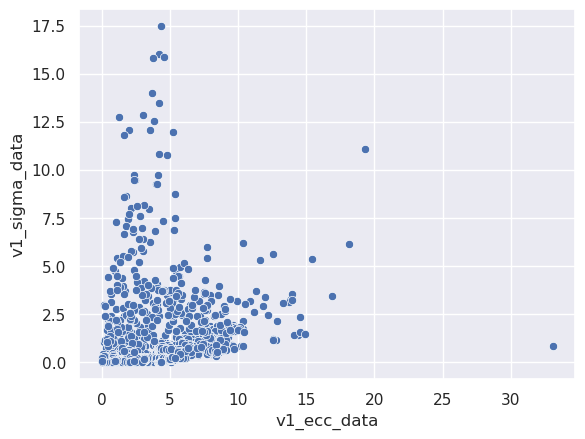

In [36]:
sns.scatterplot(x='v1_ecc_data',y='v1_sigma_data',data=prf_df_subj1_all_rois.query("v1_ecc_data < 35 & v1_sigma_data < 20 & v1_r2_data > 0"));
# plt.xlim(0,35)
# plt.ylim(0,20)

In [37]:
import binsreg

def binscatter(**kwargs):
    # Estimate binsreg
    est = binsreg.binsreg(**kwargs);
    
    # Retrieve estimates
    df_est = pd.concat([d.dots for d in est.data_plot])
    df_est = df_est.rename(columns={'x': kwargs.get("x"), 'fit': kwargs.get("y")})
    
    # Add confidence intervals
    if "ci" in kwargs:
        df_est = pd.merge(df_est, pd.concat([d.ci for d in est.data_plot]))
        df_est = df_est.drop(columns=['x'])
        df_est['ci'] = df_est['ci_r'] - df_est['ci_l']
    
    # Rename groups
    if "by" in kwargs:
        df_est['group'] = df_est['group'].astype(df[kwargs.get("by")].dtype)
        df_est = df_est.rename(columns={'group': kwargs.get("by")})

    return df_est;

In [38]:
def plot_binned_scatter(prf_df, sub):
    
    df_est_v1 = binscatter(x='v1_ecc_data',y='v1_sigma_data',
                           data=prf_df.query("v1_ecc_data < 4.5 & v1_sigma_data < 20 & v1_r2_data > 0"), 
                           ci=(3,3),randcut=1);
    df_est_v2 = binscatter(x='v2_ecc_data',y='v2_sigma_data',
                           data=prf_df.query("v2_ecc_data < 4.5 & v2_sigma_data < 20 & v2_r2_data > 0"), 
                           ci=(3,3),randcut=1);
    df_est_v3 = binscatter(x='v3_ecc_data',y='v3_sigma_data',
                           data=prf_df.query("v3_ecc_data <4.5 & v3_sigma_data < 20 & v3_r2_data > 0"), 
                           ci=(3,3),randcut=1);
    df_est_v4= binscatter(x='v4_ecc_data',y='v4_sigma_data',
                           data=prf_df.query("v4_ecc_data < 4.5 & v4_sigma_data < 20 & v4_r2_data > 0"), 
                           ci=(3,3),randcut=1);
    
    # Binned scatter plot 
    fig,ax = plt.subplots()
    sns.set_palette("tab10")
    
    # sns.scatterplot(x='v1_ecc_data',y='v1_sigma_data',data=df_est_v1, label = 'V1')
    sns.regplot(x='v1_ecc_data',y='v1_sigma_data',data=df_est_v1,label = 'V1', x_jitter =.05)
    plt.errorbar('v1_ecc_data', 'v1_sigma_data', yerr='ci', data=df_est_v1, ls='', lw=2, alpha=0.2, label='');
    
    sns.regplot(x='v2_ecc_data',y='v2_sigma_data',data=df_est_v2,label = 'V2', x_jitter =.05, x_estimator=np.mean)
    # sns.scatterplot(x='v2_ecc_data',y='v2_sigma_data',data=df_est_v2, label = 'V2')
    plt.errorbar('v2_ecc_data', 'v2_sigma_data', yerr='ci', data=df_est_v2, ls='', lw=2, alpha=0.2,label='');

    sns.regplot(x='v3_ecc_data',y='v3_sigma_data',data=df_est_v3,label = 'V3',x_jitter =.05, x_estimator=np.mean)
    # sns.scatterplot(x='v3_ecc_data',y='v3_sigma_data',data=df_est_v3, label = 'V3')
    plt.errorbar('v3_ecc_data', 'v3_sigma_data', yerr='ci', data=df_est_v3, ls='', lw=2, alpha=0.2,label='');

    sns.regplot(x='v4_ecc_data',y='v4_sigma_data',data=df_est_v4,label = 'V4',x_jitter =.05, x_estimator=np.mean)
    # sns.scatterplot(x='v4_ecc_data',y='v4_sigma_data',data=df_est_v4, label = 'V4')
    plt.errorbar('v4_ecc_data', 'v4_sigma_data', yerr='ci', data=df_est_v4, ls='', lw=2, alpha=0.2,label='');

    ax.set(xlabel = 'Eccentricity', ylabel = 'Sigma',title =f'Subject: {sub}')
    ax.legend()
    plt.show()
    

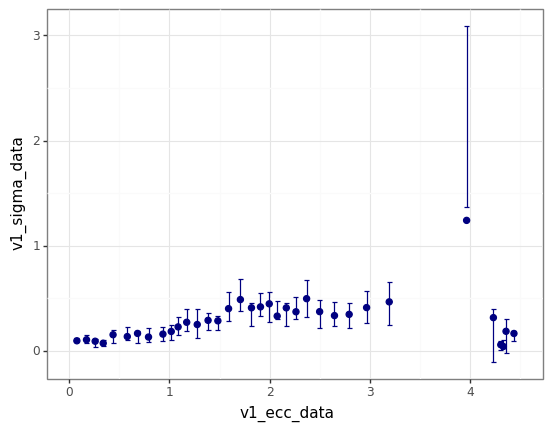

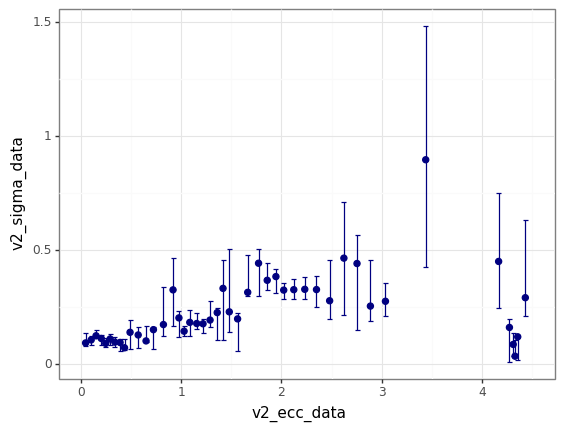

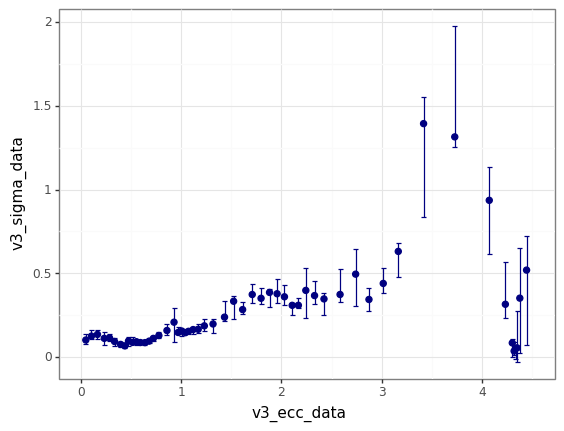

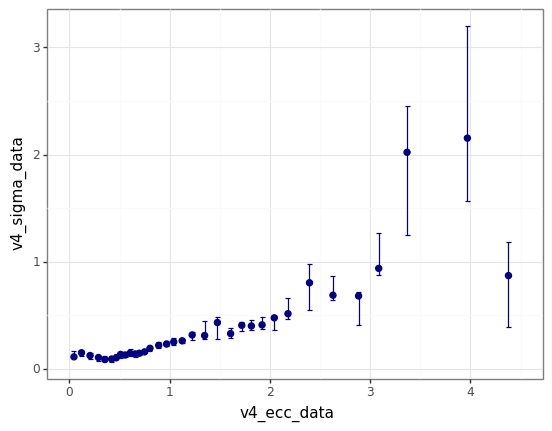

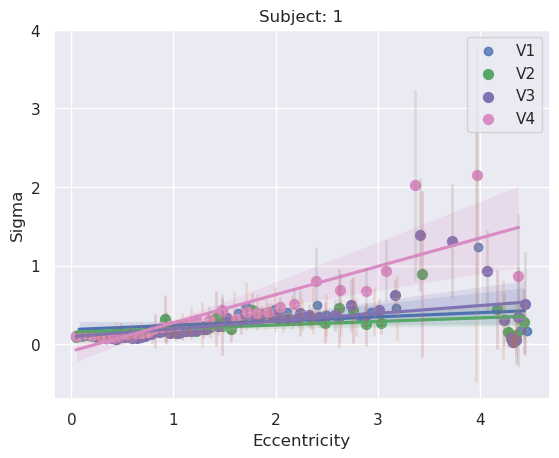

In [39]:
plot_binned_scatter(prf_df_subj1_all_rois, sub = '1')

In [73]:
prf_subj_2_all_roi = load_all_rois_prf_subject(subject = '2')
prf_df_subj2_all_rois = create_df_from_prfdata_all_rois(subject = '2')

Loaded file prf_R2.nii.gz
Loaded file prf_size.nii.gz
Loaded file prf_eccentricity.nii.gz
Loaded file prf_angle.nii.gz
Loaded file prf_exponent.nii.gz
Loaded file prf_gain.nii.gz
Loaded file prf_meanvol.nii.gz


/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/nilearn/signal.py:69: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.


Calucated for ROI: v1
Calucated for ROI: v2
Calucated for ROI: v3
Calucated for ROI: v4
Calucated for ROI: ofa
Calucated for ROI: ffa1
Calucated for ROI: ffa2
Calucated for ROI: atl
Calucated for ROI: eba
CANNOT compute for fba1, empty mask
Calucated for ROI: fba2
Calucated for ROI: opa
Calucated for ROI: ppa
Calucated for ROI: rsc
Calucated for ROI: owfa
Calucated for ROI: vwfa_1
Calucated for ROI: vwfa_2
Calucated for ROI: mfs_words
Calucated for ROI: mtl_words
Calucated for ROI: vo1
Calucated for ROI: vo2
Calucated for ROI: phc1
Calucated for ROI: phc2
Calucated for ROI: mst
Calucated for ROI: hmt
Calucated for ROI: lo2
Calucated for ROI: lo1
Calucated for ROI: v3b
Calucated for ROI: v3a
Calucated for ROI: ips0
Calucated for ROI: ips1
Calucated for ROI: ips2
Calucated for ROI: ips3
Calucated for ROI: ips4
Calucated for ROI: ips5
Calucated for ROI: spl1
Calucated for ROI: fef


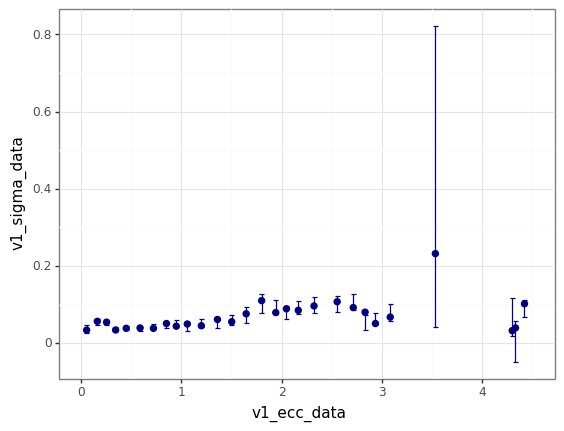

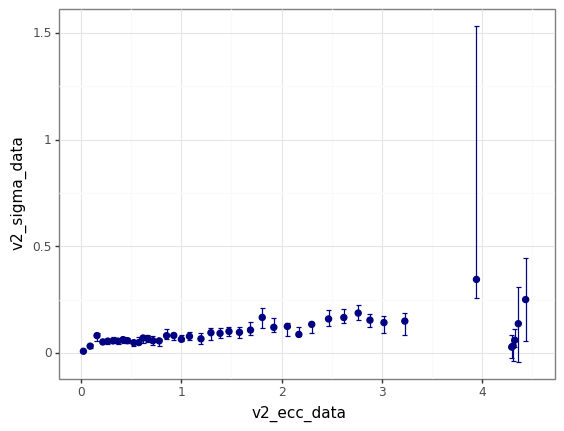

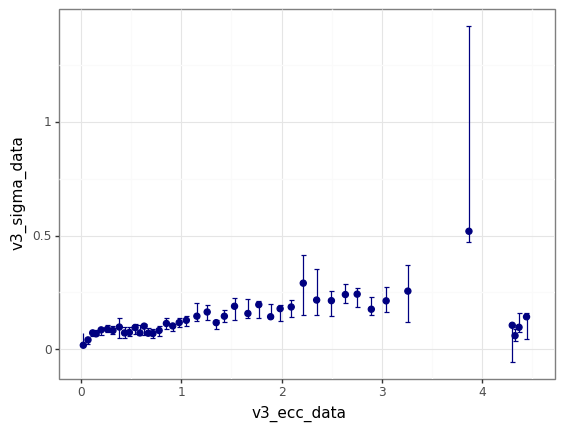

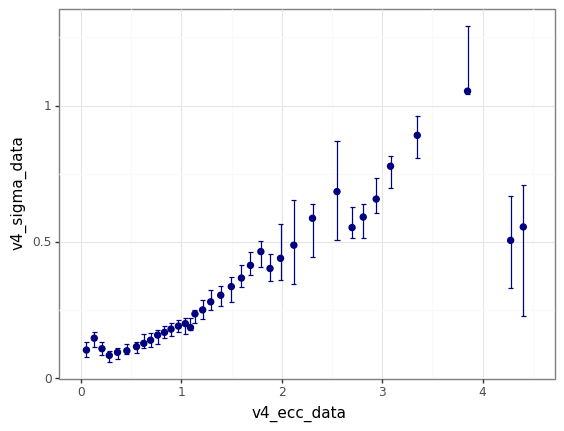

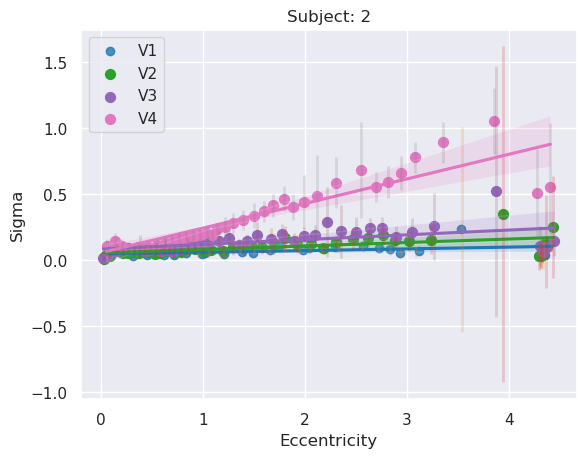

In [75]:
plot_binned_scatter(prf_df_subj2_all_rois, sub = '2')

In [76]:
prf_subj_3_all_roi = load_all_rois_prf_subject(subject = '3')
prf_df_subj3_all_rois = create_df_from_prfdata_all_rois(subject = '3')

Loaded file prf_R2.nii.gz
Loaded file prf_size.nii.gz
Loaded file prf_eccentricity.nii.gz
Loaded file prf_angle.nii.gz
Loaded file prf_exponent.nii.gz
Loaded file prf_gain.nii.gz
Loaded file prf_meanvol.nii.gz


/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/nilearn/signal.py:69: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.


Calucated for ROI: v1
Calucated for ROI: v2
Calucated for ROI: v3
Calucated for ROI: v4
Calucated for ROI: ofa
Calucated for ROI: ffa1
Calucated for ROI: ffa2
Calucated for ROI: atl
Calucated for ROI: eba
Calucated for ROI: fba1
Calucated for ROI: fba2
Calucated for ROI: opa
Calucated for ROI: ppa
Calucated for ROI: rsc
Calucated for ROI: owfa
Calucated for ROI: vwfa_1
Calucated for ROI: vwfa_2
Calucated for ROI: mfs_words
CANNOT compute for mtl_words, empty mask
Calucated for ROI: vo1
Calucated for ROI: vo2
Calucated for ROI: phc1
Calucated for ROI: phc2
Calucated for ROI: mst
Calucated for ROI: hmt
Calucated for ROI: lo2
Calucated for ROI: lo1
Calucated for ROI: v3b
Calucated for ROI: v3a
Calucated for ROI: ips0
Calucated for ROI: ips1
Calucated for ROI: ips2
Calucated for ROI: ips3
Calucated for ROI: ips4
Calucated for ROI: ips5
Calucated for ROI: spl1
Calucated for ROI: fef


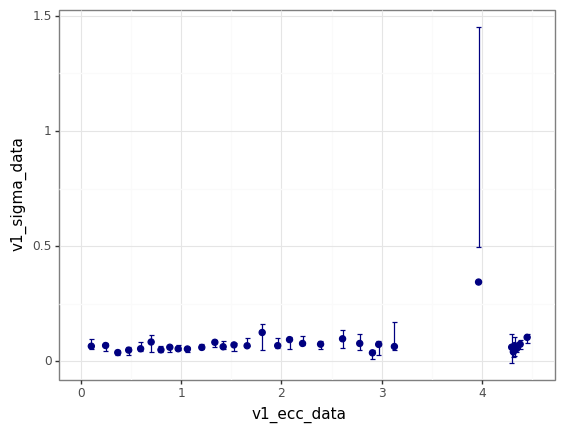

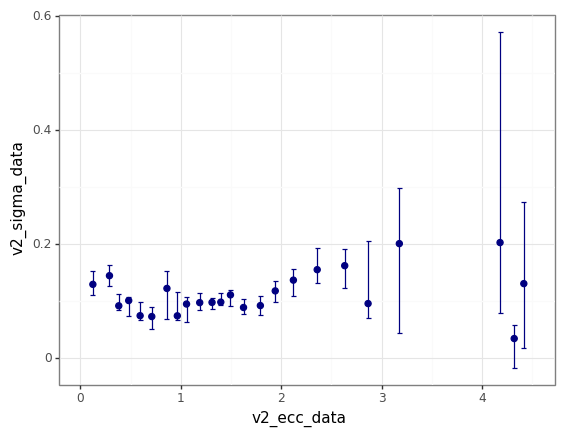

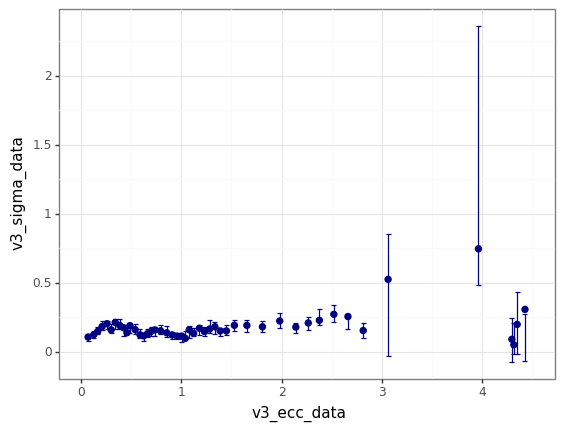

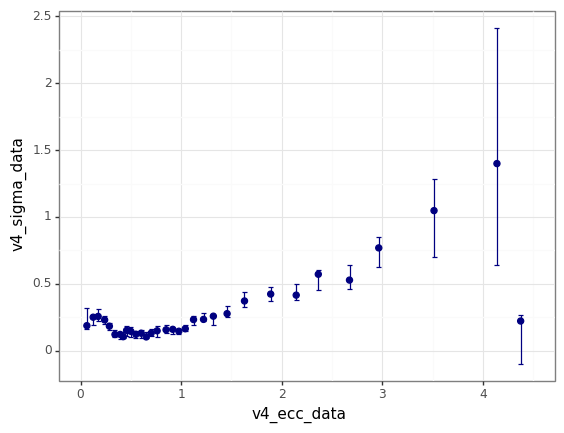

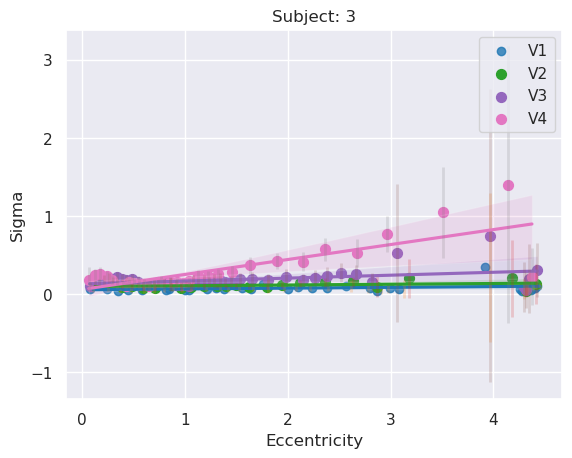

In [79]:
plot_binned_scatter(prf_df_subj3_all_rois,'3')

In [77]:
prf_subj_4_all_roi = load_all_rois_prf_subject(subject = '4')
prf_df_subj4_all_rois = create_df_from_prfdata_all_rois(subject = '4')

Loaded file prf_R2.nii.gz
Loaded file prf_size.nii.gz
Loaded file prf_eccentricity.nii.gz
Loaded file prf_angle.nii.gz
Loaded file prf_exponent.nii.gz
Loaded file prf_gain.nii.gz
Loaded file prf_meanvol.nii.gz


/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/nilearn/signal.py:69: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.


Calucated for ROI: v1
Calucated for ROI: v2
Calucated for ROI: v3
Calucated for ROI: v4
Calucated for ROI: ofa
Calucated for ROI: ffa1
Calucated for ROI: ffa2
CANNOT compute for atl, empty mask
Calucated for ROI: eba
Calucated for ROI: fba1
Calucated for ROI: fba2
Calucated for ROI: opa
Calucated for ROI: ppa
Calucated for ROI: rsc
Calucated for ROI: owfa
Calucated for ROI: vwfa_1
Calucated for ROI: vwfa_2
Calucated for ROI: mfs_words
Calucated for ROI: mtl_words
Calucated for ROI: vo1
Calucated for ROI: vo2
Calucated for ROI: phc1
Calucated for ROI: phc2
Calucated for ROI: mst
Calucated for ROI: hmt
Calucated for ROI: lo2
Calucated for ROI: lo1
Calucated for ROI: v3b
Calucated for ROI: v3a
Calucated for ROI: ips0
Calucated for ROI: ips1
Calucated for ROI: ips2
Calucated for ROI: ips3
Calucated for ROI: ips4
Calucated for ROI: ips5
Calucated for ROI: spl1
Calucated for ROI: fef


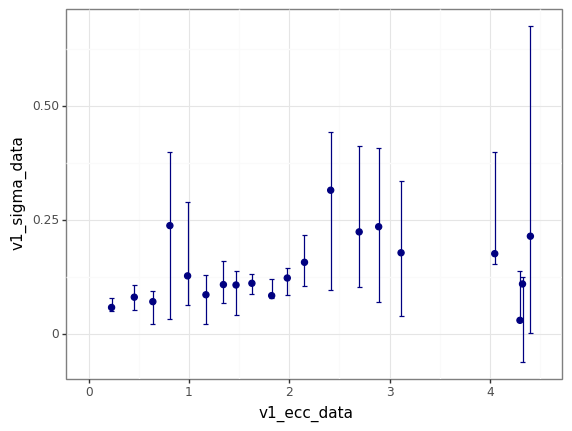

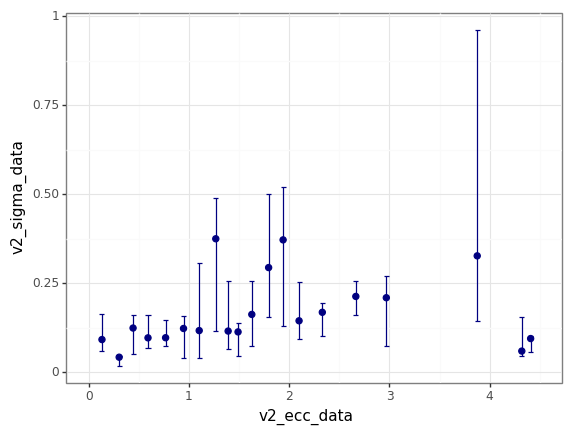

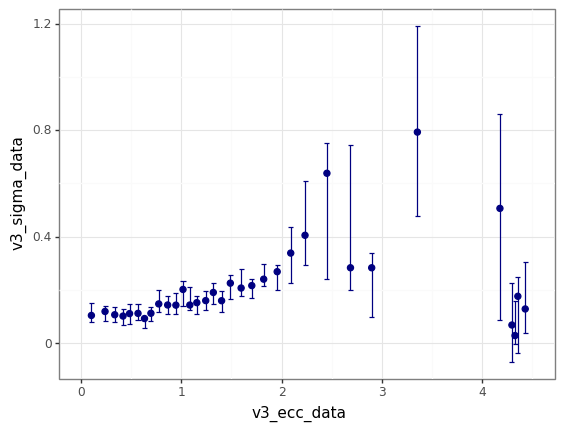

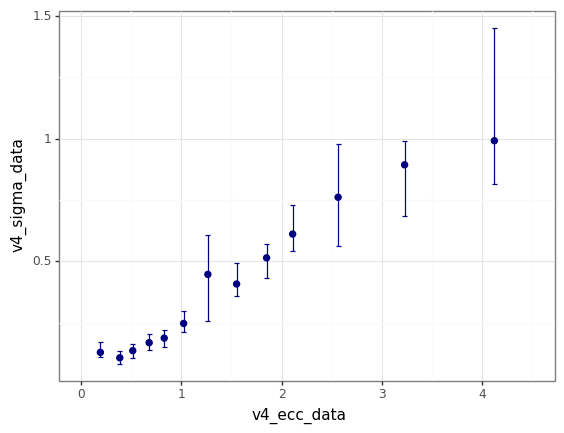

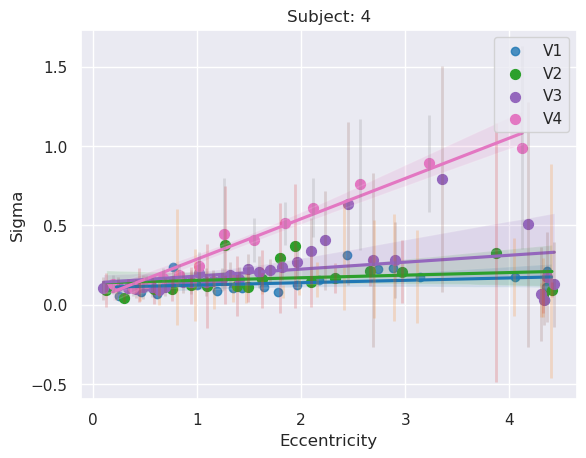

In [78]:
plot_binned_scatter(prf_df_subj4_all_rois,'4')

In [41]:
# # Save pandas datasets for the 4 subjects to disk
# prf_df_subj1.to_pickle(DATA_PATH+"/prf_df_subj1.pkl")
# prf_df_subj2.to_pickle(DATA_PATH+"/prf_df_subj2.pkl")
# prf_df_subj3.to_pickle(DATA_PATH+"/prf_df_subj3.pkl")
# prf_df_subj4.to_pickle(DATA_PATH+"/prf_df_subj4.pkl")

In [82]:
# prf_df_subj1_all_roi = create_df_from_prfdata_all_rois('1')


# prf_subj_2_all_roi = load_rois_prf_subject('2')
# prf_df_subj2_all_roi = create_df_from_prfdata('2')

# prf_subj_3_all_roi = load_rois_prf_subject('3')
# prf_df_subj3_all_roi = create_df_from_prfdata('3')

# prf_subj_4_all_roi = load_rois_prf_subject('4')
# prf_df_subj4_all_roi = create_df_from_prfdata('4')


prf_df_subj1_all_rois.to_pickle(DATA_PATH+"/prf_df_subj1_all_rois.pkl")
prf_df_subj2_all_rois.to_pickle(DATA_PATH+"/prf_df_subj2_all_rois.pkl")
prf_df_subj3_all_rois.to_pickle(DATA_PATH+"/prf_df_subj3_all_rois.pkl")
prf_df_subj4_all_rois.to_pickle(DATA_PATH+"/prf_df_subj4_all_rois.pkl")

In [38]:
!pwd

/gpfs01/bartels/user/hbhatnagar/nsd-static-saliency/scripts


In [85]:
# plot_binned_scatter(prf_df_subj2)
# plot_binned_scatter(prf_df_subj3)
# plot_binned_scatter(prf_df_subj4)